In [1]:
"""" 
compute wind power for Hurricane Lee and plot 
(1) RTOFS surface.now hourly analysis data & 
(2) GFS sfc data (forecast hours: 1-6)
"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
from scipy import interpolate
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from convert_dir import vector_dir_to_from
from mystats import bandpass
from values_to_colors import values_to_rgba
sys.path.insert(0, path_nhchi+'area-master')
# "area" library is from https://github.com/scisco/area
from area import area

In [2]:
year = '2023'
pathG = '/Users/chi/Documents/projects/sd-ni-wp/check_model/check_GFS/GFS.merge.sfc.20230904-20230922.nc'
pathR = '/Users/chi/Documents/projects/sd-ni-wp/check_model/check_RTOFS/RTOFS.merge.surface.now.20230905-20230922.nc'

dsG = nc.Dataset(pathG)
dsR = nc.Dataset(pathR)
print(dsG)
print('====================')
print(dsR)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for GFS sfc data between 20230904 and 20230922
    subtitle: Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution.
    dimensions(sizes): time(456), longitude(615), latitude(329)
    variables(dimensions): float64 time(time), float64 LON(latitude, longitude), float64 LAT(latitude, longitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for RTOFS surface.now. data between 20230905 and 20230922
    subtitle: Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal resolution.
    dimensions(sizes): time(432), depth(1), longitude(901), latitude(551)
    variables(dimensions): float64 depth(depth), float64 time(time), flo

In [3]:
print(dsR['U_VELOCITY'].shape, dsR['LONGITUDE'].shape)
print(np.nanmin(dsR['U_VELOCITY']),np.nanmax(dsR['U_VELOCITY']))
print('='*30)
print(dsG['UFLX_AVE'].shape, dsG['LON'].shape)
print(np.nanmin(dsG['UFLX_AVE']),np.nanmax(dsG['UFLX_AVE']))

(432, 1, 551, 901) (551, 901)
-3.4128530025482178 1.2676506002282294e+30
(456, 329, 615) (329, 615)
-4.999680995941162 5.723142623901367


In [4]:
''' Read RTOFS data '''
## read data & set limits of the box
LON_R = dsR['LONGITUDE'][:]
LON_R[LON_R> 180] = LON_R[LON_R> 180]-360
LAT_R = dsR['LATITUDE'][:]
U_R = np.squeeze( dsR['U_VELOCITY'][:] )
V_R = np.squeeze( dsR['V_VELOCITY'][:] )
U_R[U_R> 1e3] = np.nan
V_R[V_R> 1e3] = np.nan
dtime_R = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=dt) \
                  for dt in dsR['time'][:]])
print('shape of LON_R, LAT_R, V_R:',LON_R.shape, LAT_R.shape, V_R.shape)

shape of LON_R, LAT_R, V_R: (551, 901) (551, 901) (432, 551, 901)


In [5]:
print('RTOFS longitude & latitude limits:',np.min(LON_R),np.max(LON_R),np.min(LAT_R),np.max(LAT_R))
print('RTOFS time limits:',np.min(dtime_R),np.max(dtime_R))

RTOFS longitude & latitude limits: -101.9200439453125 -29.9200439453125 7.577810764312744 45.77324676513672
RTOFS time limits: 2023-09-04 00:00:00 2023-09-21 23:00:00


lengths of ilat, ilon: 506 500


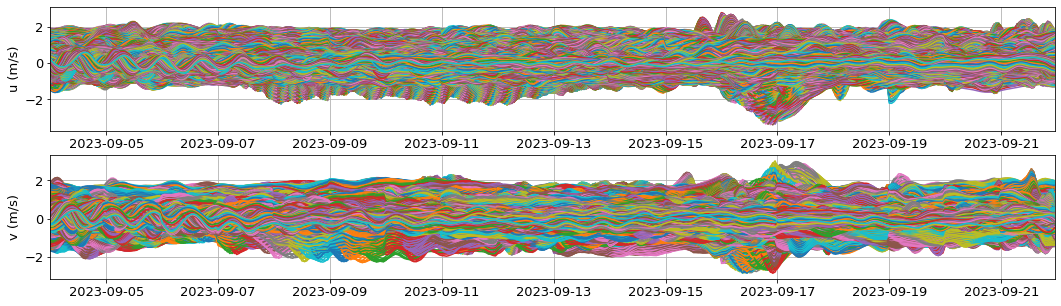

In [ ]:
''' Give a lon/ lat limits and plot time series of u/v
'''
lonlim = np.array([-80, -40])
latlim = np.array([10, 45])
### 
ilon = np.where( (LON_R[0,:]>= lonlim[0]) & (LON_R[0,:]< lonlim[1]) )[0]
ilat = np.where( (LAT_R[:,0]>= latlim[0]) & (LAT_R[:,0]< latlim[1]) )[0]
print('lengths of ilat, ilon:',len(ilat),len(ilon))
### go through each selected grid (don't need to plot)
# plt.clf()
# plt.gcf().set_size_inches(18, 5)
# plt.rcParams.update({'font.size': 13})
# for i in ilat:
#     for j in ilon:
#         u_this = np.squeeze( U_R[:,i,j] )
#         v_this = np.squeeze( V_R[:,i,j] )
#         plt.subplot(2,1,1)
#         plt.plot(dtime_R, u_this)
#         plt.subplot(2,1,2)
#         plt.plot(dtime_R, v_this)

# for i in range(2):
#     plt.subplot(2,1,i+1)
#     plt.xlim([np.min(dtime_R),np.max(dtime_R)])
#     plt.grid()
#     if i == 0:
#         plt.ylabel('u (m/s)')
#     if i == 1:
#         plt.ylabel('v (m/s)')
# ### save figure
# plt.savefig('timeseries_uv(RTOFS.merge.surface.now.20230905-20230922)_{:.2f}-{:.2f}N_{:.2f}-{:.2f}'\
#             .format(latlim[0],latlim[1],lonlim[0],lonlim[1])+'.png',dpi=400,bbox_inches='tight')

Lat_R[ilat]: (506,)


Text(0.5, 0.98, 'Range of Lat., Coriolis frequency and inertial period here')

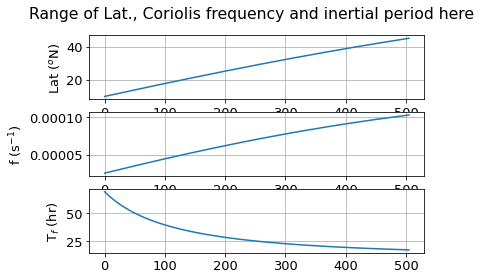

In [101]:
''' For each latitude, give a frequency limit to filter timeseries to NI band 
(try 0.9f-1.1f for each latitudes)'''
u_bp = np.nan*np.ones( (len(dtime_R), len(ilat), len(ilon)) )
v_bp = u_bp.copy()
f_lat = 2*(2*np.pi/86400)*np.sin(LAT_R[ilat,0]/180*np.pi) # 1/s
T_lat = 2*np.pi/f_lat/3600 # hr
print('Lat_R[ilat]:',LAT_R[ilat,0].shape)
plt.subplot(3,1,1)
plt.plot(LAT_R[ilat,0]); plt.ylabel('Lat ($^o$N)'); plt.grid()
plt.subplot(3,1,2)
plt.plot(f_lat); plt.ylabel('f (s$^{-1}$)'); plt.grid()
plt.subplot(3,1,3)
plt.plot(T_lat); plt.ylabel('T$_f$ (hr)'); plt.grid()
plt.suptitle('Range of Lat., Coriolis frequency and inertial period here')

In [102]:
''' go through each grid and compute bandpass (NI) current velocities 
(~1 mins per latitude with 40 degree longitudes)''' 
n_f = np.array([0.8,1.2])
dsec_RTOFS = (dtime_R[1]-dtime_R[0]).total_seconds()
###
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
for icnt,i in enumerate( ilat ):
    f_bp = np.array([n_f[0]*f_lat[icnt], n_f[1]*f_lat[icnt]])
    bp_sec = 2*np.pi/f_bp
    for jcnt,j in enumerate( ilon ):
        u_bp[:,icnt,jcnt],_,_,_,_ = bandpass( np.squeeze( U_R[:,i,j] ), dsec_RTOFS,bp_sec[0],bp_sec[1],2 )
        v_bp[:,icnt,jcnt],_,_,_,_ = bandpass( np.squeeze( V_R[:,i,j] ), dsec_RTOFS,bp_sec[0],bp_sec[1],2 )
    print('Done with',LAT_R[i,j])

Done with 10.028401374816895
Done with 10.107169151306152
Done with 10.185917854309082
Done with 10.264647483825684
Done with 10.34335708618164
Done with 10.42204761505127
Done with 10.500717163085938
Done with 10.579367637634277
Done with 10.657997131347656
Done with 10.736607551574707
Done with 10.815196990966797
Done with 10.893765449523926
Done with 10.972312927246094
Done with 11.050840377807617
Done with 11.129345893859863
Done with 11.207831382751465
Done with 11.286294937133789
Done with 11.364736557006836
Done with 11.443157196044922
Done with 11.521556854248047
Done with 11.599933624267578
Done with 11.678288459777832
Done with 11.756621360778809
Done with 11.834932327270508
Done with 11.913220405578613
Done with 11.991485595703125
Done with 12.06972885131836
Done with 12.147948265075684
Done with 12.22614574432373
Done with 12.304319381713867
Done with 12.38247013092041
Done with 12.46059799194336
Done with 12.538702011108398
Done with 12.616781234741211
Done with 12.6948375

<Figure size 1296x360 with 0 Axes>

In [33]:
### No need to plot every time (save time)
rgba, norm, cmap = values_to_rgba(LAT_R[ilat,0],'turbo',latlim[0],latlim[1])
# plt.clf()
# plt.gcf().set_size_inches(18, 5)
# plt.rcParams.update({'font.size': 13})
# for icnt,i in enumerate( ilat ):
#     if i< len(ilat):
#         for jcnt,j in enumerate( ilon ):
#             if (LON_R[i,j] >-67) & (LON_R[i,j]< -62):
#                 plt.subplot(2,1,1)
#                 plt.plot(dtime_R, u_bp[:,icnt,jcnt],color=rgba[i])
#                 plt.subplot(2,1,2)
#                 plt.plot(dtime_R, v_bp[:,icnt,jcnt],color=rgba[i])
#                 # print(LON_R[i,j], LAT_R[i,j])
# for i in range(2):
#     plt.subplot(2,1,i+1)
#     plt.xlim([np.min(dtime_R),np.max(dtime_R)])
#     plt.grid()
#     if i == 0:
#         plt.ylabel('u$_{bp}$ (m/s)')
#     if i == 1:
#         plt.ylabel('v$_{bp}$ (m/s)')
# ### save figure
# plt.savefig('timeseries_uv-bp(RTOFS.merge.surface.now.20230905-20230922)_{:.2f}-{:.2f}N_{:.2f}-{:.2f}'\
#             .format(latlim[0],latlim[1],lonlim[0],lonlim[1])+'.png',dpi=400,bbox_inches='tight')        

(506,) (506,)


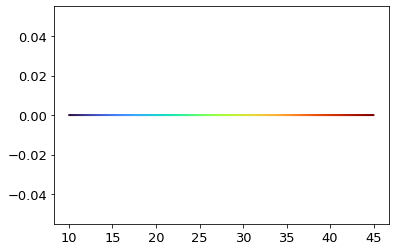

In [34]:
print(LAT_R[ilat,0].shape, rgba.shape)
plt.scatter(LAT_R[ilat,0],np.zeros(ilat.shape),s=1,c=rgba)

In [11]:
''' Read GFS data '''
## read data & set limits of the box
LON_G = dsG['LON'][:]
LON_G[LON_G> 180] = LON_G[LON_G> 180]-360
LAT_G = dsG['LAT'][:]
UFLX_AVE = np.squeeze( dsG['UFLX_AVE'][:] )
VFLX_AVE = np.squeeze( dsG['VFLX_AVE'][:] )
UFLX_AVE[UFLX_AVE> 1e3] = np.nan
VFLX_AVE[VFLX_AVE> 1e3] = np.nan
dtime_G = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=dt) \
                  for dt in dsG['time'][:]])
print('shape of LON_G, LAT_G, VFLX_AVE:',LON_G.shape, LAT_G.shape, VFLX_AVE.shape)

shape of LON_G, LAT_G, VFLX_AVE: (329, 615) (329, 615) (456, 329, 615)


In [ ]:
''' Interpolate surface zonal momentum flux to RTOFS spatial grids (~3 mins per one time stamp for 80W~40W, 10N~45N)'''
x_G = LON_G[0,:][:]
y_G = LAT_G[:,0][:]
ilon = np.where( (LON_R[0,:]>= lonlim[0]) & (LON_R[0,:]< lonlim[1]) )[0]
ilat = np.where( (LAT_R[:,0]>= latlim[0]) & (LAT_R[:,0]< latlim[1]) )[0]
x_R = LON_R[0,ilon][:]
y_R = LAT_R[ilat,0][:]
UFLX_AVE_onR = np.nan*np.ones( (len(dtime_R),len(y_R),len(x_R)) )
VFLX_AVE_onR = UFLX_AVE_onR.copy()
for t in range( len(dtime_R) ):
    it_G = np.where( dtime_G == dtime_R[t] )[0]
    if len(it_G) == 1:
        f_U = interpolate.interp2d(x_G,y_G,np.squeeze(UFLX_AVE[t,:,:]));
        # print(dtime_G[it_G], dtime_R[t])
        f_V = interpolate.interp2d(x_G,y_G,np.squeeze(VFLX_AVE[t,:,:]));
        for i, lat in enumerate( y_R ):
            for j, lon in enumerate( x_R ):
                UFLX_AVE_onR[t,i,j] = f_U(lon, lat)
                VFLX_AVE_onR[t,i,j] = f_V(lon, lat)
        # plt.pcolormesh(x_R, y_R, VFLX_AVE_onR[t,:,:])
        # plt.colorbar()
    print(dtime_R[t])

2023-09-04 00:00:00


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_1483/545743931.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f_U = interpolate.interp2d(x_G,y_G,np.squeeze(UFLX_AVE[t,:,:]));
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_1483/545743931.py:15: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` fo

2023-09-04 01:00:00
2023-09-04 02:00:00
2023-09-04 03:00:00
2023-09-04 04:00:00
2023-09-04 05:00:00
2023-09-04 06:00:00
2023-09-04 07:00:00
2023-09-04 08:00:00
2023-09-04 09:00:00
2023-09-04 10:00:00
2023-09-04 11:00:00
2023-09-04 12:00:00
2023-09-04 13:00:00
2023-09-04 14:00:00
2023-09-04 15:00:00
2023-09-04 16:00:00
2023-09-04 17:00:00
2023-09-04 18:00:00
2023-09-04 19:00:00
2023-09-04 20:00:00
2023-09-04 21:00:00
2023-09-04 22:00:00
2023-09-04 23:00:00
2023-09-05 00:00:00
2023-09-05 01:00:00
2023-09-05 02:00:00
2023-09-05 03:00:00
2023-09-05 04:00:00
2023-09-05 05:00:00
2023-09-05 06:00:00
2023-09-05 07:00:00
2023-09-05 08:00:00
2023-09-05 09:00:00
2023-09-05 10:00:00
2023-09-05 11:00:00
2023-09-05 12:00:00
2023-09-05 13:00:00
2023-09-05 14:00:00
2023-09-05 15:00:00
2023-09-05 16:00:00
2023-09-05 17:00:00
2023-09-05 18:00:00
2023-09-05 19:00:00
2023-09-05 20:00:00
2023-09-05 21:00:00
2023-09-05 22:00:00
2023-09-05 23:00:00
2023-09-06 00:00:00
2023-09-06 01:00:00
2023-09-06 02:00:00


In [105]:
''' write momentum flux (on RTOFS spatial grids) & RTOFS bandpass (NI) surface currents '''
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
tlim_str = dtime_R[0].strftime('%Y%m%d')+'-'+dtime_R[-1].strftime('%Y%m%d')
xylim_str = '{:.1f}N-{:.1f}N_{:.1f}-{:.1f}'.format(latlim[0],latlim[1],lonlim[0],lonlim[1])
ncfname_out = 'GFS-momFlux(RTOFS-grids)_RTOFS-NIUV({:.2f}f-{:.2f}f)_'.format(n_f[0],n_f[1])+tlim_str+'_'+xylim_str+'.nc'
ncfile = nc.Dataset(ncfname_out,mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
time_dim = ncfile.createDimension('time', len(dtime_R)) # unlimited axis (can be appended to).
lon_dim = ncfile.createDimension('longitude', UFLX_AVE_onR.shape[2] )
lat_dim = ncfile.createDimension('latitude', UFLX_AVE_onR.shape[1] )
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:{:.2f}f-{:.2f}f) surface currents \n'.format(n_f[0],n_f[1])+\
    'for '+tlim_str+', '+xylim_str
print(ncfile.title)
ncfile.subtitle="It took ~370 minutes to interpolate GFS momentum flux to RTOFS spatial grids."
print(ncfile.subtitle)
print(ncfile)
### move the writing data to new variables
if isinstance(UFLX_AVE_onR, np.ndarray):
    print('momentum flux variables are np array')
    UFLX_AVE_onR_out = UFLX_AVE_onR
    VFLX_AVE_onR_out = VFLX_AVE_onR
if isinstance(u_bp, np.ndarray):
    print('bandpass u/v variables are np array')
    u_bp_out = u_bp
    v_bp_out = v_bp
### print the sizes
# print(UFLX_AVE_onR.shape, u_bp.shape)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 432)
('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 500)
('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 506)
GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230921, 10.0N-45.0N_-80.0--40.0
It took ~370 minutes to interpolate GFS momentum flux to RTOFS spatial grids.
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230921, 10.0N-45.0N_-80.0--40.0
    subtitle: It took ~370 minutes to interpolate GFS momentum flux to RTOFS spatial grids.
    dimensions(sizes): time(432), longitude(50

In [106]:
### Creating variables
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since '+year+'-01-01'
time.long_name = 'time'
lon = ncfile.createVariable('longitude', np.float64, ('longitude',))
lon.units = 'degrees_E'
lon.long_name = 'longitude'
lat = ncfile.createVariable('latitude', np.float64, ('latitude',))
lat.units = 'degrees_M'
lat.long_name = 'latitude'
### 3D variables
vars_names_4nc = ['UFLX_AVE','VFLX_AVE','u_bp','v_bp']
long_names = ['GFS surface zonal momentum flux','GFS surface meridional momentum flux','RTOFS bandpassed u-vel','RTOFS v-vel']
units = ['N/m**2','N/m**2','m/s','m/s']
### 3: (time, latitude, longitude)
dim_cat = [3,3,3,3]
for i, vname_nc in enumerate( vars_names_4nc ):
    ### create variables with respective dimensions categorized by dim_cat
    if dim_cat[i] == 3:
        str_exec = vname_nc + "= ncfile.createVariable('" + vname_nc + "', np.float64, ('" + 'time' + "','"+ 'latitude' +"','"+ 'longitude' +"'))"
        exec(str_exec)
        print(i,str_exec)
    ### add attributes
    for item in units:
        str_exec = vname_nc + ".units = '"+ item + "'"
        exec(str_exec)
    for item in long_names:
        str_exec = vname_nc + ".long_name = '"+ item + "'"
        exec(str_exec)

0 UFLX_AVE= ncfile.createVariable('UFLX_AVE', np.float64, ('time','latitude','longitude'))
1 VFLX_AVE= ncfile.createVariable('VFLX_AVE', np.float64, ('time','latitude','longitude'))
2 u_bp= ncfile.createVariable('u_bp', np.float64, ('time','latitude','longitude'))
3 v_bp= ncfile.createVariable('v_bp', np.float64, ('time','latitude','longitude'))


0.0023148148148148147


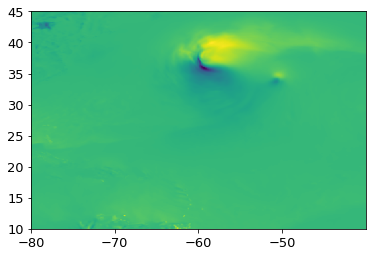

In [ ]:
print(np.sum(np.isnan(UFLX_AVE_onR))/len(UFLX_AVE_onR.flatten()))
plt.pcolormesh(x_R, y_R, UFLX_AVE_onR[1,:,:])
# plt.pcolormesh(x_R, y_R, u_bp_out[1,:,:])

In [111]:
### writing data
# Note: the ":" is necessary in these "write" statements
vars_names_out = ['UFLX_AVE_onR','VFLX_AVE_onR','u_bp_out','v_bp_out']
time[:] = dsR['time'][:]
lon[:] = x_R[:]
lat[:] = y_R[:]
for i,vname_nc in enumerate( vars_names_4nc ):
    print(vname_nc)
    if dim_cat[i] == 3:
        str_exec = vname_nc + "[:,:,:]= " + vars_names_out[i]
        exec(str_exec)    
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

UFLX_AVE
VFLX_AVE
u_bp
v_bp
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230921, 10.0N-45.0N_-80.0--40.0
    subtitle: It took ~370 minutes to interpolate GFS momentum flux to RTOFS spatial grids.
    dimensions(sizes): time(432), longitude(500), latitude(506)
    variables(dimensions): float64 time(time), float64 longitude(longitude), float64 latitude(latitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude), float64 u_bp(time, latitude, longitude), float64 v_bp(time, latitude, longitude)
    groups: 
Dataset is closed!


In [114]:
''' Compute wind power input (RTOFS spatial grids)'''
tlim_wp = [np.max([dtime_G[0],dtime_R[0]]), np.min([dtime_G[-1],dtime_R[-1]])]
print(tlim_wp)
it_G = np.where( (dtime_G>= tlim_wp[0]) & (dtime_G<= tlim_wp[1]) )[0]
it_R = np.where( (dtime_R>= tlim_wp[0]) & (dtime_R<= tlim_wp[1]) )[0]
print('GFS ({:.1f}) time limits'.format(len(dtime_G[it_G])),dtime_G[it_G][0],dtime_G[it_G][-1])
print('RTOFS ({:.1f}) time limits'.format(len(dtime_R[it_R])),dtime_R[it_R][0],dtime_R[it_R][-1])
print(UFLX_AVE_onR[it_G,:,:].shape, u_bp_out.shape)
timestamp_wp = np.array([ dtime_R[it_R][i].timestamp() for i in range( len(it_R) ) ])
''' compute wind power'''
wp = np.multiply( -UFLX_AVE_onR[it_G,:,:],u_bp_out[it_R,:,:] ) + \
    np.multiply( -VFLX_AVE_onR[it_G,:,:],v_bp_out[it_R,:,:] )
''' mean wind power of the box (for each time)'''
wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )
wp_mn_box[0] = 0
''' energy intput integrated over time '''
energy_wp = np.zeros( (len(timestamp_wp),) )
for t in range( len(timestamp_wp) ):
    energy_wp[t] = np.trapz( wp_mn_box[:t+1],timestamp_wp[:t+1] )

[datetime.datetime(2023, 9, 4, 1, 0), datetime.datetime(2023, 9, 21, 23, 0)]
GFS (431.0) time limits 2023-09-04 01:00:00 2023-09-21 23:00:00
RTOFS (431.0) time limits 2023-09-04 01:00:00 2023-09-21 23:00:00
(431, 506, 500) (432, 506, 500)


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_1483/1855268144.py:14: RuntimeWarning: Mean of empty slice
  wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )


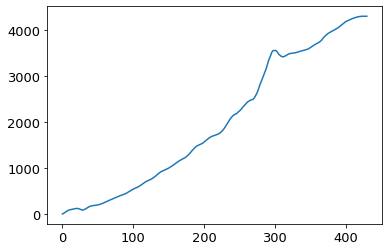

In [115]:
plt.plot(energy_wp)

In [70]:
### load topography data
path_topo = '/Users/chi/Documents/Data/Topography/GEBCO_23_Jan_2025/'
ds_topo = nc.Dataset(path_topo+'gebco_2024_n50.0_s5.0_w-98.0_e-30.0.nc')
# print(ds_topo)
lon_topo = ds_topo.variables['lon'][:]
lat_topo = ds_topo.variables['lat'][:]
elevation = ds_topo.variables['elevation'][:]
print(lon_topo.shape, lat_topo.shape, elevation.shape )

(16320,) (10800,) (10800, 16320)


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_1483/3559782193.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrow ,ncol,1)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_1483/3559782193.py:19: RuntimeWarning: All-NaN slice encountered
  data = np.nanmax( wp, axis=0 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_1483/3559782193.py:23: RuntimeWarning: All-NaN slice encountered
  data = np.nanmax( wp, axis=0 ) - np.nanmin( wp, axis=0 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_1483/3559782193.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrow ,ncol,3)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_1483/3559782193.py:27: RuntimeWarning

<Figure size 432x288 with 0 Axes>

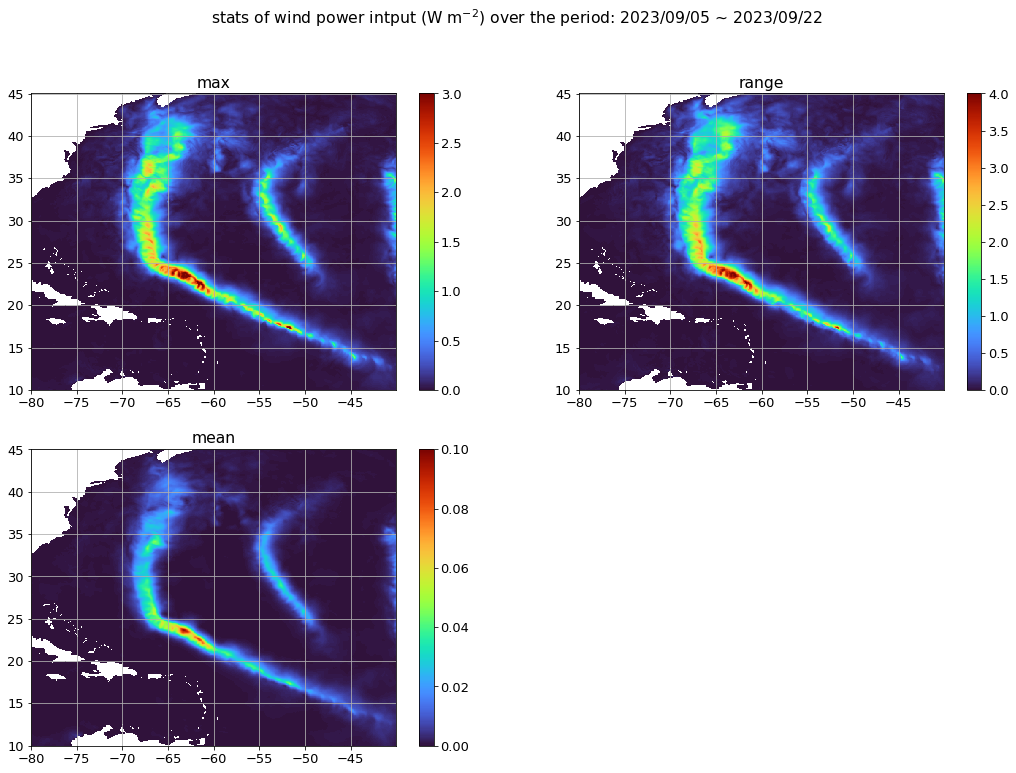

In [116]:
''' Plot map of ... over the selected period
(1) max wind power input
(2) range (max-min) of power input
(3) mean wind power
(4) 
'''
nrow = 2
ncol = 2
tlim_4_mn = [datetime.datetime(int(year),9,5),datetime.datetime(int(year),9,22)]
it_4_mn = np.where( (dtime_R[it_R]>= tlim_4_mn[0]) & (dtime_R[it_R]<= tlim_4_mn[1]) )[0]
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(18, 12)
plt.suptitle('stats of wind power intput (W m$^{-2}$) over the period: '+tlim_4_mn[0].strftime('%Y/%m/%d ~ ')+tlim_4_mn[1].strftime('%Y/%m/%d'))
str_stats = ['max','range','mean']
''' max '''
plt.subplot(nrow ,ncol,1)
data = np.nanmax( wp, axis=0 )
cs = plt.pcolormesh(x_R, y_R, data, cmap='turbo',vmin=0,vmax=3)
''' range '''
plt.subplot(nrow ,ncol,2)
data = np.nanmax( wp, axis=0 ) - np.nanmin( wp, axis=0 )
cs = plt.pcolormesh(x_R, y_R, data, cmap='turbo',vmin=0,vmax=4)
''' mean '''
plt.subplot(nrow ,ncol,3)
data = np.nanmean( wp, axis=0 )
cs = plt.pcolormesh(x_R, y_R, data, cmap='turbo',vmin=0,vmax=0.1)
for i in range( nrow*ncol-1 ):
    plt.subplot(nrow, ncol,i+1)
    plt.colorbar()
    plt.grid()
    if i< len(str_stats):
        plt.title(str_stats[i])
### save figure
plt.savefig('stats_wp({:.2f}f-{:.2f}f)_onMap('.format(n_f[0],n_f[1])+xylim_str+')_'+tlim_str+'.png',dpi=400,bbox_inches='tight')

The total area of the box is 1.403E+13 m^2 = 1.4E+07 km^2
This box input 3.960E-02 TW of power


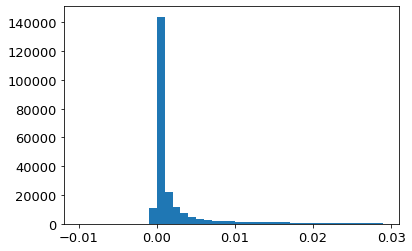

In [117]:
plt.hist(data.flatten(),np.arange(-0.01,0.03,0.001));
wp_mn = data
area_m2_total = 0
wp_total = 0
for i in range( len(x_R)-1 ):
    for j in range( len(y_R)-1 ):
        # print(x_R[i], y_R[j], wp_mn[j,i])
        if np.isnan( wp_mn[j,i] ) == 0: # only account for ocean grids
            obj = {'type':'Polygon','coordinates':[[[x_R[i],y_R[j]],[x_R[i],y_R[j+1]],\
                                                    [x_R[i+1],y_R[j+1]],[x_R[i+1],y_R[j]],[x_R[i],y_R[j]]]]}
            area_m2 = area(obj)
            # print(area_m2)
            area_m2_total = area_m2_total + area_m2
            wp_total = wp_total + wp_mn[j,i]*area_m2
            # break
print('The total area of the box is {:.3E} m^2 = {:.1E} km^2'.format(area_m2_total,area_m2_total*1e-6))
print('This box input {:.3E} TW of power'.format(wp_total*1e-12))